In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install pytorch-lightning

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import defaultdict

import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer,
    get_linear_schedule_with_warmup
)

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00" , "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

from collections import Counter

tqdm.pandas()

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/FNS_Dataset_2023/training/traindata2.csv')

In [ ]:
df.head()

,Unnamed: 0,report,summary_2,summary_3,summary_4,summary_1,summary_5,summary_6,summary_7,best_summary_index,best_summary_score
0,0,24303.04 10 November 2015 12:43 PM proof...,24303.04 10 November 2015 12:43 PM proof...,24303.04 10 November 2015 12:43 PM proof...,NaN,24303.04 10 November 2015 12:43 PM proof...,24303.04 10 November 2015 12:43 PM proof...,NaN,NaN,2,0.935185
1,1,Synergy Health plc \nAnnual Report and Accou...,2010 2011 2012 2013 2014\n286.4 287.3\n312.0\...,Synergy remains well placed \nto exploit its...,1\n2\n3\n4\n1. UK & Ireland £164.7m\n2. Europ...,Strategic report \nChief Executive's strategi...,NaN,NaN,NaN,2,1.265226
2,2,Shanks Group plc Annual Report and Accounts 2...,2 shanks. annual report 2008\nfinancial highl...,shanks. annual report 2008 3\nchairman’s stat...,NaN,4 shanks. annual report 2008\nI joined as Gro...,NaN,NaN,NaN,3,0.707809
3,3,Annual Report & Accounts\n2012 Contents\nWynn...,1 Wynnstay Group Plc Annual Report & Accounts...,6 www.wynnstay.co.uk\nOVERVIEW\nIn my first s...,4 www.wynnstay.co.uk\nOur business at a glanc...,10 www.wynnstay.co.uk\nINTRODUCTION \nThe Gro...,NaN,NaN,NaN,2,1.131579
4,4,HSBC Holdings plc \nAnnual Report and Account...,HSBC HOLDINGS PLC \nReport of the Directors: ...,HSBC HOLDINGS PLC \nReport of the Directors: ...,NaN,7\nOverview Operating & Financial Review Gove...,NaN,NaN,NaN,2,0.721190


In [ ]:
import pandas as pd

r = []
s = []

for index, row in df.iterrows():
    report = row['report']
    summary = " "
    n_sum = 0
    cnt=0
    for i in range(7):
        if not pd.isna(row[f'summary_{i+1}']):
            n_sum += 1
            summary += " " + str(row[f'summary_{i+1}'])
            cnt+= len(row[f'summary_{i+1}'].split(" "))

    report_split = report.split(" ")
    sum_split = summary.split(" ")

    r.append(len(report_split))
    if n_sum != 0:
        s.append(int(cnt/n_sum))
    else:
        s.append(0)  # Avoid division by zero if there are no valid summaries

In [ ]:
# Assuming you have a DataFrame 'df' and want to count words in non-NaN summaries of row 231

summary_word_counts = []  # List to store word counts of non-NaN summaries
row = df.iloc[231]  # Accessing row 231

for i in range(7):
    summary = row[f'summary_{i+1}']
    if not pd.isna(summary):
        word_count = len(str(summary).split())
        summary_word_counts.append(word_count)

print(summary_word_counts)  # Prints word counts of non-NaN summaries in row 231

[2708, 417, 6544]


In [ ]:
print(np.mean(r),np.mean(s))

44755.028224483096 1015.2395799146701


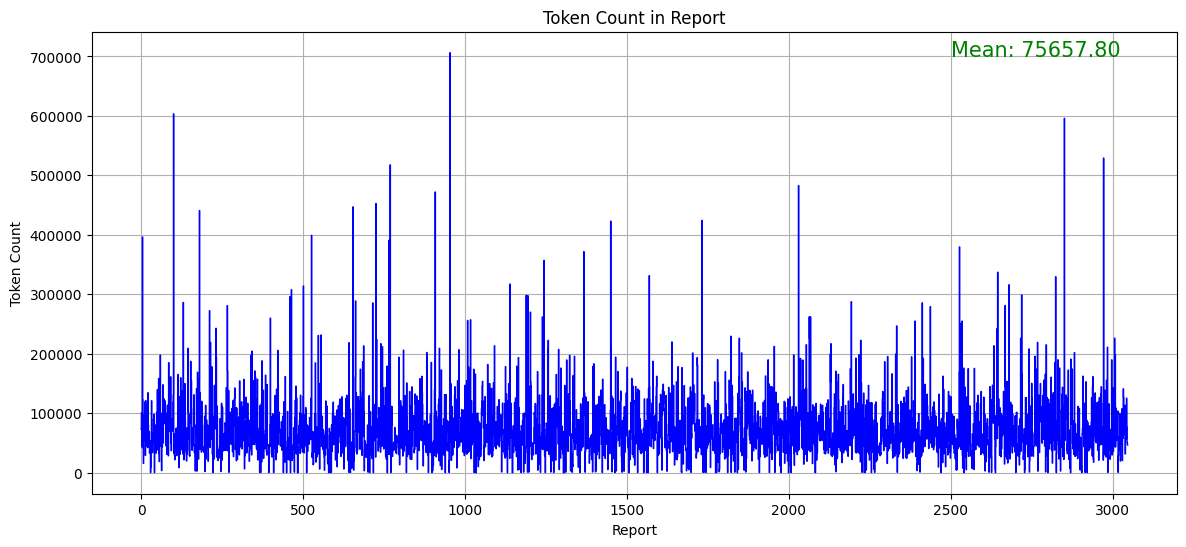

In [ ]:
import matplotlib.pyplot as plt

# Assuming you already have 'r' (report word counts)
x = range(len(r))  # Creating x-axis values
mean_count = np.mean(text_token_counts)
# Creating a step plot
plt.figure(figsize=(14, 6))
plt.step(x, text_token_counts, where='mid', color='blue', linewidth=1.0)
plt.xlabel('Report')
plt.ylabel('Token Count')
plt.title('Token Count in Report')
plt.text(2500,700000, f'Mean: {mean_count:.2f}', fontsize=15, color='green')
plt.grid(True)
plt.show()

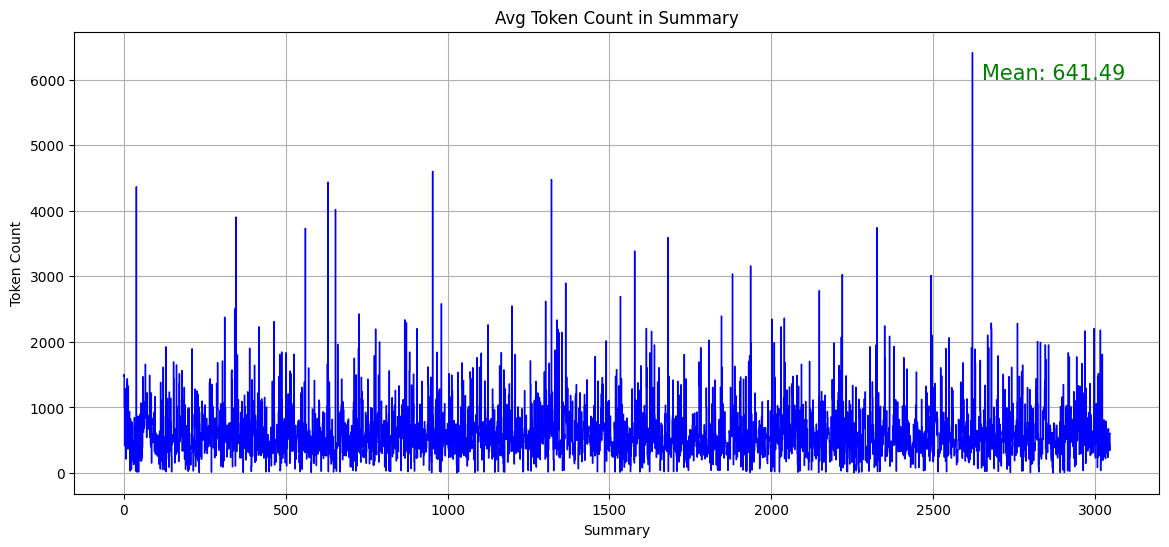

In [ ]:
import matplotlib.pyplot as plt

# Assuming you already have 'r' (report word counts)
x = range(len(r))  # Creating x-axis values
mean_count_S = np.mean(summary_token_counts)
# Creating a step plot
plt.figure(figsize=(14, 6))
plt.step(x, summary_token_counts, where='mid', color='blue', linewidth=1.0)
plt.xlabel('Summary')
plt.ylabel('Token Count')
plt.title('Avg Token Count in Summary')
plt.text(2650,6000, f'Mean: {mean_count_S:.2f}', fontsize=15, color='green')
plt.grid(True)
plt.show()

In [ ]:
len(summary_token_counts)

3047

In [ ]:
df=df.iloc[:800]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          800 non-null    int64  
 1   report              800 non-null    object 
 2   summary_2           798 non-null    object 
 3   summary_3           799 non-null    object 
 4   summary_4           192 non-null    object 
 5   summary_1           796 non-null    object 
 6   summary_5           25 non-null     object 
 7   summary_6           0 non-null      object 
 8   summary_7           0 non-null      object 
 9   best_summary_index  800 non-null    int64  
 10  best_summary_score  800 non-null    float64
dtypes: float64(1), int64(2), object(8)
memory usage: 68.9+ KB


# Report - Summary Length Distribution

In [ ]:
text_token_counts, summary_token_counts = [], []
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
#for index, row in traindf.iterrows():
    text = row['report']
    text_token_count = len(tokenizer.encode(text))
    text_token_counts.append(text_token_count)

    summary_index = int(row['best_summary_index'])  # Ensure it's an integer
    summary = 'summary_' + str(summary_index)
    summary_text = row[summary]
    try:
      summary_token_count = len(tokenizer.encode(summary_text))
    except Exception as err:
      print(row['id'],summary)
    summary_token_counts.append(summary_token_count)

  0%|          | 0/3047 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (73117 > 1024). Running this sequence through the model will result in indexing errors


<Axes: ylabel='Count'>

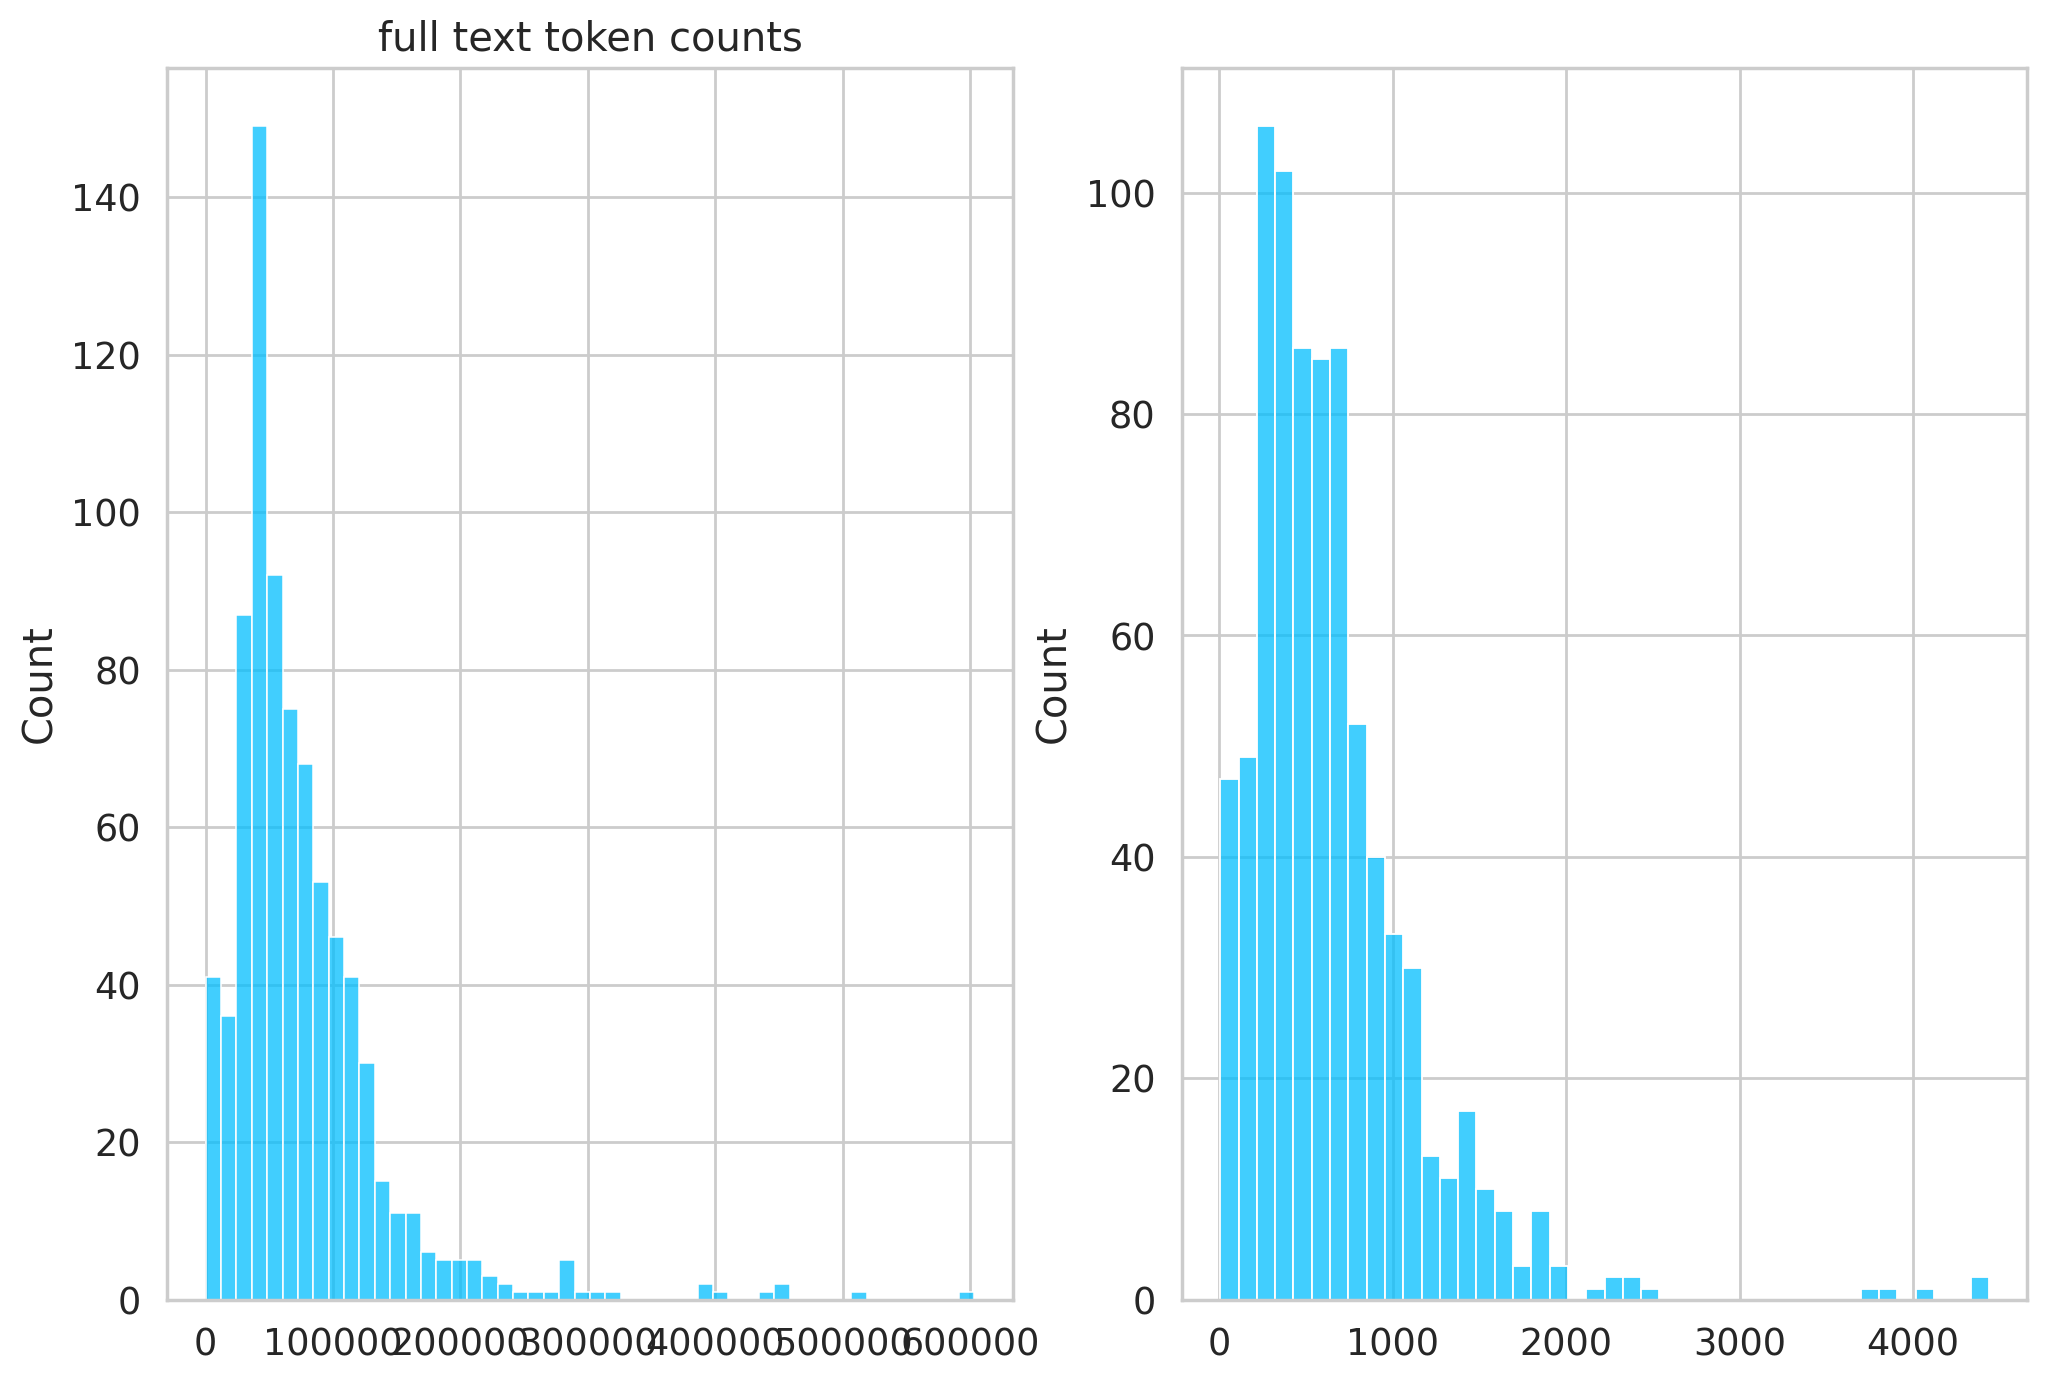

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.histplot(text_token_counts, ax=ax1)
ax1.set_title('full text token counts')
sns.histplot(summary_token_counts, ax=ax2)

In [ ]:
np.mean(text_token_counts), np.mean(summary_token_counts)

(75538.47, 644.83375)

In [ ]:
import pandas as pd

# Function to retrieve summary data based on best_summary_index
def get_summary(row):
    best_summary_index = row['best_summary_index']
    summary_column = f'summary_{best_summary_index}'
    return row[summary_column]

# Apply the function to create the 'source' column
df['target'] = df.apply(get_summary, axis=1)

In [ ]:
columns_to_keep = ['report', 'target']  # Replace 'target' with the actual column name you want to keep

# Drop columns that are not in the list of columns to keep
df.drop(df.columns.difference(columns_to_keep), axis=1, inplace=True)


In [ ]:
df.rename(columns = {'report':'source'}, inplace = True)
df

,source,target
0,24303.04 10 November 2015 12:43 PM proof...,24303.04 10 November 2015 12:43 PM proof...
1,Synergy Health plc \nAnnual Report and Accou...,2010 2011 2012 2013 2014\n286.4 287.3\n312.0\...
2,Shanks Group plc Annual Report and Accounts 2...,shanks. annual report 2008 3\nchairman’s stat...
3,Annual Report & Accounts\n2012 Contents\nWynn...,1 Wynnstay Group Plc Annual Report & Accounts...
4,HSBC Holdings plc \nAnnual Report and Account...,HSBC HOLDINGS PLC \nReport of the Directors: ...
...,...,...
795,2006\nWalker Greenbank PLC\nAnnual Report and...,Walker Greenbank PLC Annual Reports and Accou...
796,DS Smith Plc\nBeech House\nWhitebrook Park\n6...,Adjusted operating proﬁt\n£136.1m\n2010: £98....
797,Christie Group plc\nWhitefriars House\n6 Carm...,REVENUE BY DIVISION\nREVENUE BY SECTOR\n2011 ...
798,iSOFT Group plc\n2005 annual report and accou...,01\n75.5%\nTurnover growth of 75.5%\nto £262....


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2)
train_df.shape, test_df.shape

((640, 2), (160, 2))

# Create the Model

In [ ]:
import sys
import transformers
import pandas as pd
import numpy as np
import glob
import math
import random
import re
import argparse
import nltk
from transformers import Trainer, TrainingArguments

In [ ]:
pip install transformers

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW, BartConfig

tokenizer = BartTokenizer.from_pretrained('facebook/bart-large', add_prefix_space=True)

bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large")

(…)large/resolve/main/tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

(…)ebook/bart-large/resolve/main/vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

(…)ebook/bart-large/resolve/main/merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

(…)k/bart-large/resolve/main/tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

(…)book/bart-large/resolve/main/config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

In [ ]:
new_tokens = ['<F>', '<RLC>', '<A>', '<S>', '<P>', '<R>', '<RPC>']

special_tokens_dict = {'additional_special_tokens': new_tokens}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
bart_model.resize_token_embeddings(len(tokenizer))

Embedding(50272, 1024)

In [ ]:
import glob
from nltk import tokenize
import nltk
import transformers
from torch.utils.data import DataLoader, TensorDataset, random_split, RandomSampler, Dataset
import pandas as pd
import numpy as np
import torch.nn.functional as F
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint

class LitModel(pl.LightningModule):
  # Instantiate the model
  def __init__(self, learning_rate, tokenizer, model):
    super().__init__()
    self.tokenizer = tokenizer
    self.model = model
    self.learning_rate = learning_rate
    # self.freeze_encoder = freeze_encoder
    # self.freeze_embeds_ = freeze_embeds
#     self.hparams = argparse.Namespace()

    self.hparams.freeze_encoder = True
    self.hparams.freeze_embeds = True
    self.hparams.eval_beams = 4
    # self.hparams = hparams

    if self.hparams.freeze_encoder:
      freeze_params(self.model.get_encoder())

    if self.hparams.freeze_embeds:
      self.freeze_embeds()

  def freeze_embeds(self):
    ''' freeze the positional embedding parameters of the model; adapted from finetune.py '''
    freeze_params(self.model.model.shared)
    for d in [self.model.model.encoder, self.model.model.decoder]:
      freeze_params(d.embed_positions)
      freeze_params(d.embed_tokens)

  # Do a forward pass through the model
  def forward(self, input_ids, **kwargs):
    return self.model(input_ids, **kwargs)

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate)
    return optimizer

  def training_step(self, batch, batch_idx):
    # Load the data into variables
    src_ids, src_mask = batch[0], batch[1]
    tgt_ids = batch[2]
    # Shift the decoder tokens right (but NOT the tgt_ids)
    decoder_input_ids = shift_tokens_right(tgt_ids, self.tokenizer.pad_token_id)

    # Run the model and get the logits
    outputs = self(src_ids, attention_mask=src_mask, decoder_input_ids=decoder_input_ids, use_cache=False)
    lm_logits = outputs[0]
    # Create the loss function
    ce_loss_fct = torch.nn.CrossEntropyLoss(ignore_index=self.tokenizer.pad_token_id)
    # Calculate the loss on the un-shifted tokens
    loss = ce_loss_fct(lm_logits.view(-1, lm_logits.shape[-1]), tgt_ids.view(-1))

    return {'loss':loss}

  def validation_step(self, batch, batch_idx):

    src_ids, src_mask = batch[0], batch[1]
    tgt_ids = batch[2]

    decoder_input_ids = shift_tokens_right(tgt_ids, self.tokenizer.pad_token_id)

    # Run the model and get the logits
    outputs = self(src_ids, attention_mask=src_mask, decoder_input_ids=decoder_input_ids, use_cache=False)
    lm_logits = outputs[0]

    ce_loss_fct = torch.nn.CrossEntropyLoss(ignore_index=self.tokenizer.pad_token_id)
    val_loss = ce_loss_fct(lm_logits.view(-1, lm_logits.shape[-1]), tgt_ids.view(-1))

    return {'loss': val_loss}

  # Method that generates text using the BartForConditionalGeneration's generate() method
  def generate_text(self, text, eval_beams, early_stopping = True, max_len = 1024):
    ''' Function to generate text '''
    generated_ids = self.model.generate(
        text["input_ids"],
        attention_mask=text["attention_mask"],
        use_cache=True,
        decoder_start_token_id = self.tokenizer.pad_token_id,
        num_beams= eval_beams,
        max_length = max_len,
        early_stopping = early_stopping
    )
    return [self.tokenizer.decode(w, skip_special_tokens=True, clean_up_tokenization_spaces=True) for w in generated_ids]

def freeze_params(model):
  ''' Function that takes a model as input (or part of a model) and freezes the layers for faster training
      adapted from finetune.py '''
  for layer in model.parameters():
    layer.requires_grade = False


# Create a dataloading module as per the PyTorch Lightning Docs
class SummaryDataModule(pl.LightningDataModule):
  def __init__(self, tokenizer, df, batch_size):
    super().__init__()
    self.tokenizer = tokenizer
    self.batch_size = batch_size
    self.data = df

  # Loads and splits the data into training, validation and test sets with a 60/20/20 split
  def prepare_data(self):
    self.train, self.validate, self.test = np.split(self.data.sample(frac=1), [int(.6*len(self.data)), int(.8*len(self.data))])

  # encode the sentences using the tokenizer
  def setup(self, stage):
    self.train = encode_sentences(self.tokenizer, self.train['source'], self.train['target'])
    self.validate = encode_sentences(self.tokenizer, self.validate['source'], self.validate['target'])
    self.test = encode_sentences(self.tokenizer, self.test['source'], self.test['target'])

  # Load the training, validation and test sets in Pytorch Dataset objects
  def train_dataloader(self):
    dataset = TensorDataset(self.train['input_ids'], self.train['attention_mask'], self.train['labels'])
    train_data = DataLoader(dataset, sampler = RandomSampler(dataset), batch_size = self.batch_size)
    return train_data

  def val_dataloader(self):
    dataset = TensorDataset(self.validate['input_ids'], self.validate['attention_mask'], self.validate['labels'])
    val_data = DataLoader(dataset, batch_size = self.batch_size)
    return val_data

  def test_dataloader(self):
    dataset = TensorDataset(self.test['input_ids'], self.test['attention_mask'], self.test['labels'])
    test_data = DataLoader(dataset, batch_size = self.batch_size)
    return test_data



def shift_tokens_right(input_ids, pad_token_id):
  """ Shift input ids one token to the right, and wrap the last non pad token (usually <eos>).
      This is taken directly from modeling_bart.py
  """
  prev_output_tokens = input_ids.clone()
  index_of_eos = (input_ids.ne(pad_token_id).sum(dim=1) - 1).unsqueeze(-1)
  prev_output_tokens[:, 0] = input_ids.gather(1, index_of_eos).squeeze()
  prev_output_tokens[:, 1:] = input_ids[:, :-1]
  return prev_output_tokens

def encode_sentences(tokenizer, source_sentences, target_sentences, max_length=1024, min_length = 512, pad_to_max_length=True, return_tensors="pt"):
  ''' Function that tokenizes a sentence
      Args: tokenizer - the BART tokenizer; source and target sentences are the source and target sentences
      Returns: Dictionary with keys: input_ids, attention_mask, target_ids
  '''

  input_ids = []
  attention_masks = []
  target_ids = []
  tokenized_sentences = {}

  for sentence in source_sentences:
    encoded_dict = tokenizer(
          sentence,
          max_length=max_length,
          padding="max_length" if pad_to_max_length else None,
          truncation=True,
          return_tensors=return_tensors,
          add_prefix_space = True
      )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

  input_ids = torch.cat(input_ids, dim = 0)
  attention_masks = torch.cat(attention_masks, dim = 0)

  for sentence in target_sentences:
    encoded_dict = tokenizer(
          sentence,
          max_length=min_length,
          padding="max_length" if pad_to_max_length else None,
          truncation=True,
          return_tensors=return_tensors,
          add_prefix_space = True
      )
    # Shift the target ids to the right
    # shifted_target_ids = shift_tokens_right(encoded_dict['input_ids'], tokenizer.pad_token_id)
    target_ids.append(encoded_dict['input_ids'])

  target_ids = torch.cat(target_ids, dim = 0)


  batch = {
      "input_ids": input_ids,
      "attention_mask": attention_masks,
      "labels": target_ids,
  }

  return batch

In [ ]:
summary_data = SummaryDataModule(tokenizer, train_df, batch_size = 1)
model = LitModel(learning_rate = 2e-5, tokenizer = tokenizer, model = bart_model)

NameError: ignored

In [ ]:
trainer = pl.Trainer(max_epochs = 3,
                     min_epochs = 2,
                     precision = 16)

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, summary_data)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                         | Params
-------------------------------------------------------
0 | model | BartForConditionalGeneration | 406 M 
-------------------------------------------------------
406 M     Trainable params
0         Non-trainable params
406 M     Total params
1,625.194 Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
trainer.save_checkpoint("/content/drive/MyDrive/FNS_Dataset_2023/training/fns_output.ckpt")

In [ ]:
!ls -lh

total 6.5G
drwx------ 2 root root 4.0K Oct  2 08:32 annual_reports
-rw------- 1 root root 4.6G Oct  9 07:23 fns_output.ckpt
drwx------ 2 root root 4.0K Oct  4 07:48 gold_summaries
-rw------- 1 root root 964M Oct  8 17:35 traindata2.csv
-rw------- 1 root root 964M Oct  5 12:37 traindata.csv


#Generate summaries

In [ ]:
model=bart_model
bart_model = LitModel.load_from_checkpoint("/content/drive/MyDrive/FNS_Dataset_2023/training/fns_output.ckpt",learning_rate = 2e-5, tokenizer = tokenizer, model = model)

In [ ]:
def summarizeText(text):
    text_encoding = tokenizer(
        text,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    generated_ids = bart_model.model.generate(
        input_ids=text_encoding['input_ids'],
        attention_mask=text_encoding['attention_mask'],
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )

    preds = [
            tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for gen_id in generated_ids
    ]
    return "".join(preds)

In [ ]:
sample_row = test_df.iloc[1]
text = sample_row['source']
model_summary = summarizeText(text)

In [ ]:
sample_row

source     Annual Report  \nand Accounts 2016\nGrainger ...
target     Net rental income\n1\n£37.4m +15%\n(FY15: £32...
Name: 667, dtype: object

In [ ]:
print(len(text))
text

485727


' Annual Report  \nand Accounts 2016\nGrainger plc Annual Report and Accounts 2016 More online\nwww.graingerplc.co.uk\nOur purpose\nThe UK Private Rented Sector (‘PRS’) presents \na\xa0major opportunity as more people are choosing \nto rent. \nWe plan to capture this opportunity. We are \nthe\xa0UK’s largest residential landlord listed on \nthe\xa0London Stock Exchange and have a clear, \nfocused strategy to significantly grow our portfolio \nof homes for rent and deliver sustainable returns \nto\xa0our Shareholders while providing our customers \nwith great homes to\xa0live\xa0in.\nBuilding on our growing national portfolio of \n8,609 rental homes, we plan to invest over £1bn \ninto the UK’s private rented sector by\xa02020. We \nwill execute this plan with our unrelenting focus \non growing net rental income, driving operational \nefficiency and improving customer service – to \nthe benefit of our Shareholders and customers. \nContents\nStrategic report \n1 Highlights\n2 The Grainger

In [ ]:
print(len(model_summary))
model_summary

46


' Grainger plc Annual Report and Accounts 2016\n'

In [ ]:
x=model_summary.split('\n')
x

[' Annual Report  ',
 'and Accounts 2016',
 'Grainger plc Annual Report and Accounts 2016 More online',
 'www.graingerplc.co.uk',
 'Our purpose',
 'The UK Private Rented Sector (‘PRS’) presents ',
 'a\xa0major opportunity as more people are choosing ',
 'to rent. ',
 'We plan to capture this opportunity. We have a clear, ',
 'focused strategy to significantly grow our portfolio ',
 'of homes for rent and deliver sustainable returns ',
 'from\xa0our Shareholders while providing our customers ',
 'with great homes to\xa0live\xa0in.',
 'Building on our growing national portfolio of ',
 '8,609 rental homes, we plan to invest over £1bn ',
 '']